<a href="https://colab.research.google.com/github/GaborVxxx/ml_notes/blob/main/L5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi class classification problem

* Binary classification = the output is in 2 category only
* Multi class classification = the output can be more than 2 thing

In [65]:
import torch, sklearn
import matplotlib.pyplot as plt
from torch import nn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

In [66]:
# Utils
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

In [67]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [68]:
# Constants
NUM_CLASSES = 4 # = output features
NUM_FEATURES = 2 # = input features
RANDOM_SEED = 42
NUM_SAMPLES = 1000
NUM_EPOCHS = 1000
LEARNING_RATE = 0.01
TEST_SIZE = 0.2

In [69]:
# Create multi class data
X_blob, y_blob = make_blobs(n_samples=NUM_SAMPLES,
                  n_features=NUM_FEATURES,
                  centers=NUM_CLASSES,
                  cluster_std=1.5, # give it some noise
                  random_state=RANDOM_SEED)

In [70]:
X_blob.shape, y_blob.shape

((1000, 2), (1000,))

In [71]:
X_blob[:5], y_blob[:5]

(array([[-8.41339595,  6.93516545],
        [-5.76648413, -6.43117072],
        [-6.04213682, -6.76610151],
        [ 3.95083749,  0.69840313],
        [ 4.25049181, -0.28154475]]),
 array([3, 2, 2, 1, 1]))

In [72]:
# Make tensors
X_blob = torch.from_numpy(X_blob).to(torch.float32)
y_blob = torch.from_numpy(y_blob).to(torch.float32)
X_blob[:5], y_blob[:5]

(tensor([[-8.4134,  6.9352],
         [-5.7665, -6.4312],
         [-6.0421, -6.7661],
         [ 3.9508,  0.6984],
         [ 4.2505, -0.2815]]),
 tensor([3., 2., 2., 1., 1.]))

In [73]:
# Slit to training and test data
X_train, X_test, y_train, y_test = train_test_split(X_blob,
                                                    y_blob,
                                                    test_size=TEST_SIZE,
                                                    random_state=RANDOM_SEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape
print(f"X_train:\n {X_train[:5]} \n y_train:\n {y_train[:5]}")
print(f"X_test:\n {X_test[:5]} \n y_test:\n {y_test[:5]}")

X_train:
 tensor([[ 5.0405,  3.3076],
        [-2.6249,  9.5260],
        [-8.5240, -9.0402],
        [-6.0262, -4.4375],
        [-3.3397,  7.2175]]) 
 y_train:
 tensor([1., 0., 2., 2., 0.])
X_test:
 tensor([[ 4.6675,  4.4878],
        [-7.9969,  6.8803],
        [-6.2801, -7.8571],
        [ 3.6833,  1.1767],
        [-0.1404, 10.1654]]) 
 y_test:
 tensor([1., 3., 2., 1., 0.])


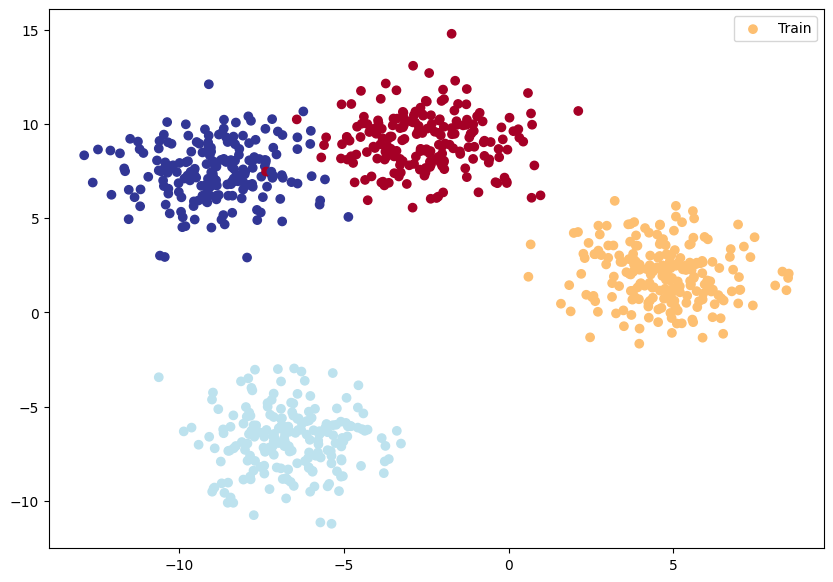

In [74]:
# Plot the data how it look like
plt.figure(figsize=(10, 7))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.RdYlBu)
plt.legend(['Train'])
plt.show()

# Visual exemple of what we building

https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=xor&regDataset=reg-plane&learningRate=0.1&regularizationRate=0&noise=0&networkShape=5,5,2&seed=0.53070&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false

In [75]:
# Build the model
class ModelMultiClass(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=32):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=input_features, out_features=hidden_units) # this will take 2 features and extend it to 32 nodes
    self.layer_2 = nn.Linear(in_features=hidden_units, out_features=hidden_units) # this will take 32 features and extend it to 32 nodes
    self.layer_3 = nn.Linear(in_features=hidden_units, out_features=output_features) # this will take 32 features and extend it to 4 nodes (output features)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p=0.2)
    self.batchnorm1 = nn.BatchNorm1d(32)
    self.batchnorm2 = nn.BatchNorm1d(32)

  def forward(self, x):
    x = self.layer_1(x)
    x = self.relu(x)
    x = self.batchnorm1(x)
    x = self.dropout(x) # add random dropout to make data more versatile
    x = self.layer_2(x)
    x = self.relu(x)
    x = self.batchnorm2(x)
    x = self.layer_3(x)
    return x

In [76]:
# Inisialize model
model = ModelMultiClass(input_features=NUM_FEATURES,
                       output_features=NUM_CLASSES,
                       hidden_units=32).to(device)
model

ModelMultiClass(
  (layer_1): Linear(in_features=2, out_features=32, bias=True)
  (layer_2): Linear(in_features=32, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=4, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [77]:
# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [78]:
# Put data to device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [79]:
# Build the loop

for epoch in range(NUM_EPOCHS):
  model.train()

  y_logits = model(X_train)

  y_pred = torch.softmax(y_logits, dim=1) # NOTE: we dont have to calculate softmax as the nn.CrossEntropyLoss() take logits and it do softmax calculation any way, and we not even use this value, we only use it for accurecy calculation

  acc = accuracy_fn(y_true=y_train, y_pred=y_pred.argmax(dim=1)) # this function take 2 array, the lables and the prediction, here we need to use soft max to get the probablility and pick out the top probablility and use it as athe predicted lable

  loss = loss_fn(y_logits, y_train.long()) # take int only for nn.CrossEntropyLoss()

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model.eval()
  with torch.inference_mode():

    y_logits_test = model(X_test)

    y_pred_test = torch.softmax(y_logits_test, dim=1) # NOTE: we dont have to calculate softmax as the nn.CrossEntropyLoss() take logits and it do softmax calculation any way, and we not even use this value, we only use it for accurecy calculation

    test_acc = accuracy_fn(y_true=y_test, y_pred=y_pred_test.argmax(dim=1)) # this function take 2 array, the lables and the prediction, here we need to use soft max to get the probablility and pick out the top probablility and use it as athe predicted lable

    test_loss = loss_fn(y_logits_test, y_test.long()) # take int only for nn.CrossEntropyLoss()

    if epoch % 100 == 0:
      print(f"Epoch: {epoch}, loss: {loss:.4f}, acc: {acc:.2f}% testloss: {test_loss:.4f}, test_acc: {test_acc:.2f}%")
      #print(f"X_train shape: {X_train.squeeze(dim=1).shape}, y_train shape: {y_train.shape}")
      #print(f"y_logits shape: {y_logits.shape}, y_pred shape: {y_pred.shape}")
      #print(f"y_logits shape: {y_logits.shape}, y_train.squeeze().long() shape: {y_train.squeeze().long().shape}")

Epoch: 0, loss: 1.2994, acc: 41.62% testloss: 1.2201, test_acc: 30.50%
Epoch: 100, loss: 0.2053, acc: 98.00% testloss: 0.1606, test_acc: 98.50%
Epoch: 200, loss: 0.1219, acc: 98.88% testloss: 0.0890, test_acc: 99.50%
Epoch: 300, loss: 0.0913, acc: 99.00% testloss: 0.0620, test_acc: 99.50%
Epoch: 400, loss: 0.0751, acc: 98.62% testloss: 0.0480, test_acc: 99.50%
Epoch: 500, loss: 0.0618, acc: 99.12% testloss: 0.0390, test_acc: 99.50%
Epoch: 600, loss: 0.0503, acc: 99.12% testloss: 0.0331, test_acc: 99.50%
Epoch: 700, loss: 0.0497, acc: 99.12% testloss: 0.0289, test_acc: 99.50%
Epoch: 800, loss: 0.0453, acc: 99.25% testloss: 0.0258, test_acc: 99.50%
Epoch: 900, loss: 0.0438, acc: 99.12% testloss: 0.0234, test_acc: 99.50%


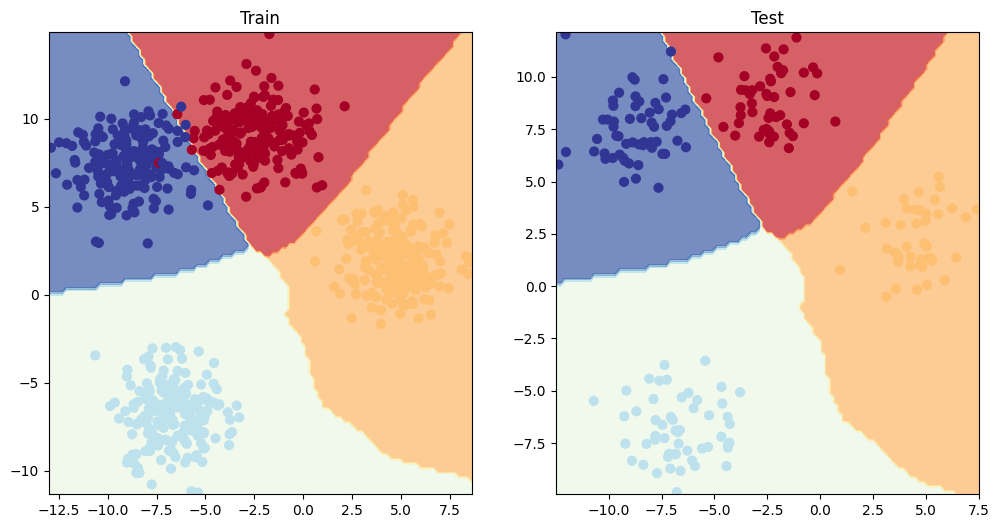

In [80]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model=model, X=X_test, y=y_test)